## **0.0 Imports**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import cluster as c

### 0.1 Helper Functions

### 0.2 Load Dataset

In [2]:
# laod dataset
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis=1)

In [3]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## **1.0 Descrição dos dados**

In [4]:
df1 = df_raw.copy()

### **1.1 Rename columns**

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns  = cols_new

### **1.2 Data dimensions**

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### **1.3 Data types**

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [8]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### **1.4 Check NA**

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### **1.5 Replace NA**

In [10]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### **1.6 Changes dTypes**

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### **1.7 Descriptive Statistics**

## **2.0 Feature Engineering**

In [14]:
df2 = df1.copy()

In [15]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


### **2.1 Feature Criation**

In [16]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [17]:
# Gross Revenue (Faturamento) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

In [18]:
# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

In [19]:
# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

In [20]:
# Frequency - Quantity 
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

In [21]:
df_ref

,customer_id,gross_revenue,recency_days,invoice_no
0,17850.0,5288.63,302,35
1,13047.0,3079.10,31,18
2,12583.0,7187.34,2,18
3,13748.0,948.25,95,5
4,15100.0,635.10,330,6
...,...,...,...,...
4367,13436.0,196.89,1,1
4368,15520.0,343.50,1,1
4369,13298.0,360.00,1,1
4370,14569.0,227.39,1,1


## **3.0 Filtragem de Variáveis**

In [22]:
df3 = df_ref.copy()

## **4.0 EDA (Exploratory Data Analysis)**

In [23]:
df4 = df3.copy()

## **5.0 Data Preparation**

In [24]:
df5 = df4.copy()

## **6.0 Feature Selection**

In [25]:
df6 = df5.copy()

## **7.0 Hyperparameter Fine Tuning**

In [26]:
X = df6.drop(columns=['customer_id'])

In [27]:
clusters = [2, 3, 4, 5, 6]

### **7.1 Within-Cluster Sum of Square (WSS)**

Text(0.5, 1.0, 'WSS vs K')

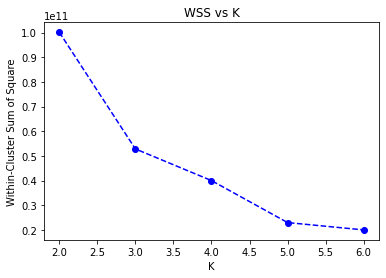

In [28]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    # validation
    wss.append(kmeans.inertia_)

# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K')

In [30]:
from yellowbrick.cluster import KElbowVisualizer

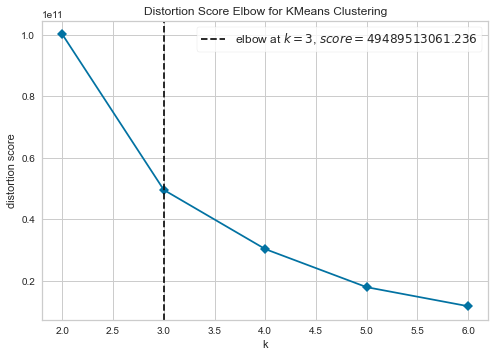

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings = False)
kmeans.fit(X)
kmeans.show()

*WSS definiu K = 3*

### **7.2 Sillhouette Score**

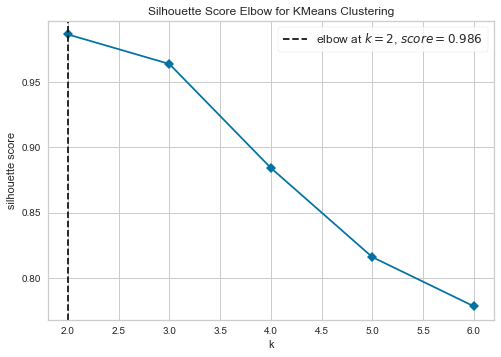

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [33]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings = False)
kmeans.fit(X)
kmeans.show()

*Silhouette Score definiu K = 2*

## **8.0 Model Training**

## **9.0 Cluster Analysis**

## **10.0 Deploy to Production**